In [33]:
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [34]:
train_data = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=['date'])
train_data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [35]:
test_data = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])
test_data

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [36]:
train_data.sort_values("date", inplace=True)
test_data.sort_values("date", inplace=True)

In [37]:
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [38]:
# Normalize features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

In [39]:
train_scaled

array([[0.12227074, 0.8209571 , 0.        , 0.13260331],
       [0.04279476, 0.90759076, 0.07058266, 0.132881  ],
       [0.0356623 , 0.84983498, 0.10974262, 0.13299381],
       ...,
       [0.24745269, 0.88063806, 0.14842886, 0.13289464],
       [0.276718  , 0.84983498, 0.17349597, 0.13265971],
       [0.12227074, 1.        , 0.        , 0.1326467 ]])

In [40]:
class weatherdata(Dataset):
    def __init__(self, data, target_index=0, seq_length=10):
        self.data = data
        self.seq_length = seq_length
        self.target_index = target_index

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length, self.target_index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [41]:
seq_len = 50
batch_size = 16

train_dataset = weatherdata(train_scaled, seq_length= seq_len)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [43]:
# train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size=4, hidden_size=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50

for e in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()

    print(f"Epoch {e+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/50, Loss: 0.0474
Epoch 2/50, Loss: 0.0058
Epoch 3/50, Loss: 0.0047
Epoch 4/50, Loss: 0.0044
Epoch 5/50, Loss: 0.0040
Epoch 6/50, Loss: 0.0041
Epoch 7/50, Loss: 0.0037
Epoch 8/50, Loss: 0.0039
Epoch 9/50, Loss: 0.0035
Epoch 10/50, Loss: 0.0035
Epoch 11/50, Loss: 0.0035
Epoch 12/50, Loss: 0.0034
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0030
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0031
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0029
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0027
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0026
Epoch 24/50, Loss: 0.0029
Epoch 25/50, Loss: 0.0027
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0026
Epoch 30/50, Loss: 0.0026
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.

In [47]:
input_seq = torch.tensor(train_scaled[-seq_len:], dtype=torch.float32).unsqueeze(0).to(device)
model.eval()
predictions = []

with torch.no_grad():
    for i in range(len(test_data)):
        out = model(input_seq)
        predictions.append(out.item())

        next_input = test_scaled[i].reshape(1,1,-1)
        input_seq = torch.cat((input_seq[:, 1:, :], torch.tensor(next_input, dtype=torch.float32).to(device)), dim=1)
    

In [48]:
# We only predicted meantemp, which is index 0
mean_temp_preds = np.array(predictions).reshape(-1, 1)
rest = np.zeros((len(predictions), len(features)-1))
full_preds = np.concatenate([mean_temp_preds, rest], axis=1)
inv_preds = scaler.inverse_transform(full_preds)[:, 0]

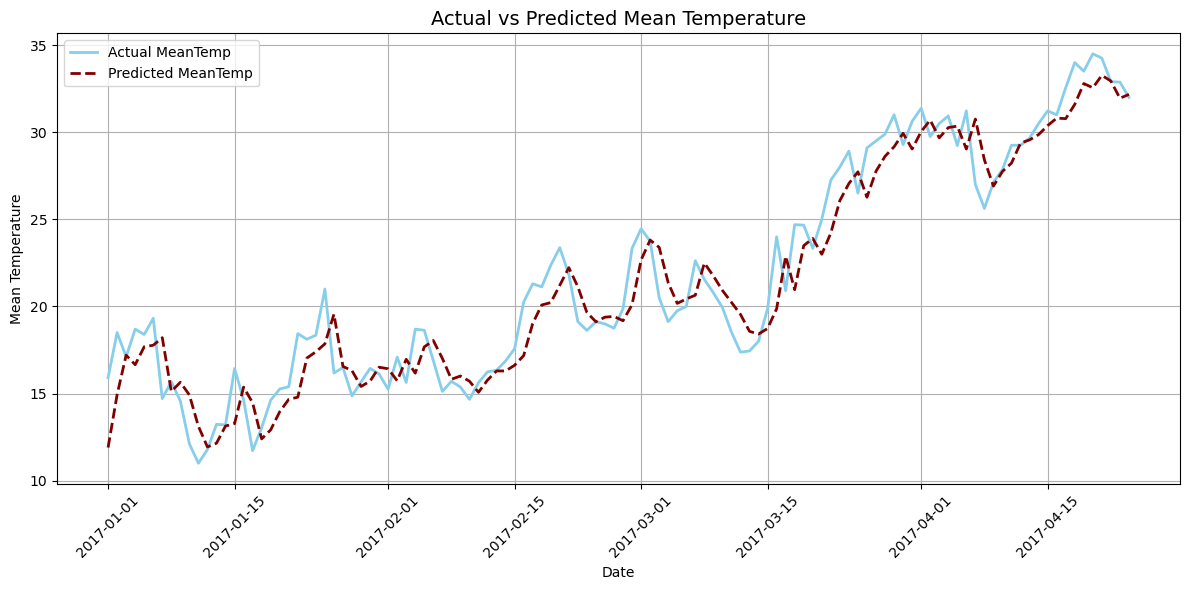

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Actual values
plt.plot(test_data['date'], test_data['meantemp'], label='Actual MeanTemp', color='skyblue', linewidth=2)

# Predicted values
plt.plot(test_data['date'], inv_preds, label='Predicted MeanTemp', color='maroon', linestyle='--', linewidth=2)

plt.title("Actual vs Predicted Mean Temperature", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()